In [66]:
import pandas as pd
# pd.options.mode.chained_assignment = None 

df_comp = pd.read_pickle('df_comp.pickle')

In [68]:
import re, csv, nltk

def csv2dict(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return {k:v for (k,v) in d}

def csv2list(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return [r[0] for r in d]

# load rubber dictionary
rub_dict = csv2dict('../rubber_dictionary/rub_dict.csv')
regex = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in rub_dict.keys()) + r')(?!\w)',re.IGNORECASE)
rub_list = csv2list('../rubber_dictionary/rub_name_list.csv')   
#rub_list = sorted(rub_list, reverse=True)

def sub_rubber_names(s,rub_dict=rub_dict,regex=regex):
    if isinstance(s, str):
        return regex.sub(lambda m: rub_dict[m.group(0).lower()],s)
    else:
        return ''

def word_process(s):
    wo = nltk.word_tokenize(s)
    return wo

def find_rubbers(s_words, rub_list=rub_list):
    l = []
    ind = []
    cnt = 0 # at present just "estimate" the character location based on summing up word lengths
    for w in s_words:
        if w in rub_list:
            l.append(w)
            ind.append(cnt)
        cnt = cnt + len(w) + 1        
    return (l,ind)

def sub_and_find_rubbers(s):
    sub = sub_rubber_names(s)
    words = word_process(sub)
    entity, entity_locs = find_rubbers(words)    
    return sub, words, entity, entity_locs


In [111]:
# helper functions
import numpy as np

def print_row_info(row):
    print('====================')    
    print('[{0}] {1}'.format(ind, row.reply_split))
    print('  rubbers: {0}'.format(row.entity))
    print('  comparative relation: {0}'.format(row.comparative))     
    print('  comparative words: {0}'.format(row.comparative_words))
    print('  comparative aspects: {0}'.format(row.comparative_aspects))    
    print('  thread title: {0}'.format(row.thread_title))
    #print(row.entity_locs)
    #print(row.comparative_word_begin_idx)

def find_aspects(row):
    col_names = row.index[8:18]
    return [s for s in col_names[row[col_names]!=0]]

def contains_rub(entity, rub_name):
    for e in entity:
        if rub_name.lower() in e.lower():
            return True
    return False

# find immediately preceding index
def find_immed_preceding(loc_list, loc):
    if len(loc_list) > 0:
        loc_sorted = np.sort(loc_list)
        ind = -1
        for i,l in enumerate(loc_sorted):
            if loc > l:
                ind = i
            else:
                break
        if ind == -1:
            return -1
        else:
            return np.where(np.argsort(loc_list)==ind)[0][0]
    else:
        return -1

def find_other_ent(ent_list, ent):
    for e in ent_list:
        if e != ent:
            return e
    return None

def sort_relation(e1,e2,w):
    print(e1)
    alph_small_entity = min(e1,e2)
    if e1 == alph_small_entity:
        eo1 = e1
        eo2 = e2
        wo = w
    else:
        eo1 = e2
        eo2 = e1
        if w == 'greater':
            wo = 'less'
        elif w == 'less':
            wo = 'greater'
        elif w == 'equal':
            wo = 'equal'
    return eo1,eo2,wo

def create_rel_entry(cid, ctxt, e1, e2, w, a):
    
    e1_ent, e2_ent, w_ent = sort_relation(e1,e2,w)
    return {'comment_id':cid,'comment_text':ctxt,\
                            'entity1':e1_ent, 'entity2':e2_ent, 'aspect':a, 'direction':w_ent[0]}
       

In [125]:
df_output = pd.DataFrame(columns=['id','comment_id','comment_text','entity1','entity2','aspect','direction'])
cnt = 0
cnt_bad = 0
for ind, row in df_comp.iterrows():
    num_entity = len(set(row.entity))
    if num_entity == 2 and len(row.comparative_words)> 0:         
        print_row_info(row)
        for w,l,a in zip(row.comparative,row.comparative_word_begin_idx,row.comparative_aspects):
            ent_ind = find_immed_preceding(row.entity_locs,l)
            if ent_ind > -1:
                entities = [row.entity[ent_ind],find_other_ent(row.entity,row.entity[ent_ind])]
                print('  almighty comparison: {0} -- {1} -- {2} -- {3}'.format(a,entities[0],w,entities[1]))
                entry = create_rel_entry(row.id,row.reply_split,entities[0],entities[1],w,a)
                df_output = df_output.append(entry, ignore_index=True)
                cnt = cnt + 1
    elif num_entity == 1 and len(row.comparative_words) > 0:   
        tit_entity = sub_and_find_rubbers(row.thread_title)[2]
        if len(set(tit_entity)) == 2 and row.entity[0] in tit_entity:
            print_row_info(row)              
            print('  thread title: {0}'.format(tit_entity))            
            for w,l,a in zip(row.comparative,row.comparative_word_begin_idx,row.comparative_aspects):
                ent_ind = find_immed_preceding(row.entity_locs,l) # meaning subject
                if ent_ind == -1:
                    ent1 = find_other_ent(tit_entity,row.entity[0])
                    ent2 = row.entity[0]
                else:
                    ent1 = row.entity[0]
                    ent2 = find_other_ent(tit_entity,row.entity[0])
                print('  almighty comparison: {0} -- {1} -- {2} -- {3}'.format(a,ent1,w,ent2))  
                entry = create_rel_entry(row.id,row.reply_split,ent1,ent2,w,a)
                df_output = df_output.append(entry, ignore_index=True)                
                cnt = cnt + 1
    
        

[2] I used T05fx before and I really appreciate the general feeling of the T64fx, which is more softer but faster than 05fx.
  rubbers: ['Butterfly-Tenergy-05-FX', 'Butterfly-Tenergy-64-FX', 'Butterfly-Tenergy-05-FX']
  comparative relation: ['greater', 'less']
  comparative words: ['faster', 'softer']
  comparative aspects: ['speed', 'hardness']
  thread title: Tenergy 05FX vs Tenergy 64FX
  almighty comparison: speed -- Butterfly-Tenergy-64-FX -- greater -- Butterfly-Tenergy-05-FX
Butterfly-Tenergy-64-FX
  almighty comparison: hardness -- Butterfly-Tenergy-64-FX -- less -- Butterfly-Tenergy-05-FX
Butterfly-Tenergy-64-FX
[56] T05 pimples are a little shorter, thicker, and closer together so the rubber feels harder.
  rubbers: ['Butterfly-Tenergy-05']
  comparative relation: ['greater']
  comparative words: ['harder']
  comparative aspects: ['hardness']
  thread title: Tenergy 05 vs Tenergy 80
  thread title: ['Butterfly-Tenergy-05', 'Butterfly-Tenergy-80']
  almighty comparison: hardn

  comparative aspects: ['hardness']
  thread title: FX-P vs FX-S
  thread title: ['Tibhar-Evolution-FX-P', 'Tibhar-Evolution-FX-S']
  almighty comparison: hardness -- Tibhar-Evolution-FX-P -- less -- Tibhar-Evolution-FX-S
Tibhar-Evolution-FX-P
[404] t05 being less spinny than GA 8 seems a bit unlikely to me, having tried both.
  rubbers: ['Butterfly-Tenergy-05']
  comparative relation: ['less']
  comparative words: ['less spin']
  comparative aspects: ['spin']
  thread title: Gold arc 8 vs tenergy 05
  thread title: ['DHS-Gold-Arc-8', 'Butterfly-Tenergy-05']
  almighty comparison: spin -- Butterfly-Tenergy-05 -- less -- DHS-Gold-Arc-8
Butterfly-Tenergy-05
[406] However, you might find it easier to generate spin with GA 8, while t05 has a higher maximum that not everybody can activate.
  rubbers: ['Butterfly-Tenergy-05']
  comparative relation: ['greater']
  comparative words: ['higher']
  comparative aspects: ['throw angle']
  thread title: Gold arc 8 vs tenergy 05
  thread title: ['DH

  almighty comparison: hardness -- DHS-Hurricane-8 -- less -- DHS-Hurricane-3
DHS-Hurricane-8
[1824] H3 neo would be close to H2 just that its a lot faster and low ball trajectory.
  rubbers: ['DHS-Hurricane-3', 'DHS-Hurricane-2']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Hurricane 3 neo vs Hurricane 8
  almighty comparison: speed -- DHS-Hurricane-2 -- greater -- DHS-Hurricane-3
DHS-Hurricane-2
[1828] Im currently using Omega V Pro and it is also similar to T05 in my point of view but it is slightly slower and less spinny but it has an incredible good control with high arc that helps to reduce errors or reduce hitting the ball into the net.
  rubbers: ['Xiom-Omega-V-Pro', 'Butterfly-Tenergy-05']
  comparative relation: ['less', 'less', 'greater']
  comparative words: ['less spin', 'slower', 'good control']
  comparative aspects: ['spin', 'speed', 'control']
  thread title: Hurricane 3 neo vs Hurricane 8
  almigh

[4778] The 05 fx has a softer sponge than the 05 so the 05 is a bit harder.
  rubbers: ['Butterfly-Tenergy-05-FX', 'Butterfly-Tenergy-05', 'Butterfly-Tenergy-05']
  comparative relation: ['less', 'greater']
  comparative words: ['softer', 'harder']
  comparative aspects: ['hardness', 'hardness']
  thread title: Tenergy 05 fx for chopping/looping
  almighty comparison: hardness -- Butterfly-Tenergy-05-FX -- less -- Butterfly-Tenergy-05
Butterfly-Tenergy-05-FX
  almighty comparison: hardness -- Butterfly-Tenergy-05 -- greater -- Butterfly-Tenergy-05-FX
Butterfly-Tenergy-05
[4780] I have found that the tenergy 80 feels a bit softer than the 05..
  rubbers: ['Butterfly-Tenergy-80', 'Butterfly-Tenergy-05']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Tenergy 05 fx for chopping/looping
  almighty comparison: hardness -- Butterfly-Tenergy-80 -- less -- Butterfly-Tenergy-05
Butterfly-Tenergy-80
[4805] The 05 fx has a softe

[5931] Both produces great kick on sidespin loops.Blocking - Moon is easier to block with, mainly due the lower catapult and less sensitivity to spin when the ball digs in.I found Moon to be more linear, whereas T05 generates more power and spin with less effort.
  rubbers: ['Galaxy-Moon', 'Galaxy-Moon', 'Butterfly-Tenergy-05']
  comparative relation: ['less']
  comparative words: [' lower']
  comparative aspects: ['throw angle']
  thread title: Galaxy / Yin-He Moon Pro
  almighty comparison: throw angle -- Galaxy-Moon -- less -- Butterfly-Tenergy-05
Galaxy-Moon
[5933] I do like the glue feel of the T05, but prefer the tacky topsheet and higher speed of the Moon.Comparing it to Thor's, I'd say I still like the Thor's better, as this also has a bit of that Tensor feel and has a higher arc, closer to T05.
  rubbers: ['Butterfly-Tenergy-05', 'Tensor-rubbers', 'Butterfly-Tenergy-05']
  comparative relation: ['greater']
  comparative words: ['higher']
  comparative aspects: ['throw angle']


[9343] Interesting...I actually found T05 easier to control than Hexer...
  rubbers: ['Butterfly-Tenergy-05', 'Andro-Hexer']
  comparative relation: ['greater']
  comparative words: ['easier to control']
  comparative aspects: ['control']
  thread title: Review: Andro Hexer according to me. (vs Roxon 450/500)
  almighty comparison: control -- Butterfly-Tenergy-05 -- greater -- Andro-Hexer
Butterfly-Tenergy-05
[9578] I would go with the G2-FX, but just because its softer, so its easier a looping game, Bryce its way to hard I think.
  rubbers: ['Butterfly-Sriver-G2-FX', 'Butterfly-Bryce']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Bryce or Sriver G2-FX?
  almighty comparison: hardness -- Butterfly-Sriver-G2-FX -- less -- Butterfly-Bryce
Butterfly-Sriver-G2-FX
[9602] Yes it's soft, but I don't find it grippier or spinnier than Bryce.
  rubbers: ['Butterfly-Bryce']
  comparative relation: ['greater', 'greater']
  com

  comparative aspects: ['throw angle']
  thread title: Rakza 7 and Rakza 9 - spin insensitive
  almighty comparison: throw angle -- Yasaka-Rakza-7 -- greater -- Yasaka-Rakza-9
Yasaka-Rakza-7
[13412] Yes some tuned Chinese rubbers might come near it, but the feeling is just so different.To answer the OPs question, yes the acuda/baracuda will feel faster than traditional rubbers like MArk V, but for loops they're often easier to land, because the extra spin you generate gives most a tighter arc, so the ball drops more easily.
  rubbers: ['Chinese-rubbers', 'Yasaka-Mark-V']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Acuda S3 and Baracuda Big Slam
  almighty comparison: speed -- Chinese-rubbers -- greater -- Yasaka-Mark-V
Chinese-rubbers
[14091] The extra head size of the XV series creates a little flex on the flared handle and it was affecting how one placed the ball.On a side note - I swopped a Xiom Vega Europe for

  comparative relation: ['greater', 'less']
  comparative words: ['spinnier', 'softer']
  comparative aspects: ['spin', 'hardness']
  thread title: KTL Red Diamond & KTL Black Power
  almighty comparison: spin -- Tensor-rubbers -- greater -- ESN-rubbers
Tensor-rubbers
[15956] Perhaps Andro Roxon 330 (slower than JE) or Hexer Powersponge (about same as JE, maybe slightly slower) if they are available.
  rubbers: ['Andro-Roxon-330', 'Andro-Hexer-Powersponge']
  comparative relation: ['less']
  comparative words: ['slower']
  comparative aspects: ['speed']
  thread title: Replace Joola Energy and Bty Solcion?
  almighty comparison: speed -- Andro-Roxon-330 -- less -- Andro-Hexer-Powersponge
Andro-Roxon-330
[16017] = Low speed for defensive game- pretty fast and powerfull for rallies, counters and loops at mid distance, very esy to take the "firststrike" shot.Very (very) spinny inverted rubbers, very tacky (Jupiter is as tacky as 729FX or Reflectoïd or H3).
  rubbers: ['Galaxy-Jupiter', 'D

  almighty comparison: weight -- Donic-Bluefire-M2 -- greater -- Yasaka-Mark-V
Donic-Bluefire-M2
[19949] V-Stage is noticeably faster than a Mark V-XS and is a low throw rubber.I'll see how long pryde lasts I play 3 times a week and spend quite a bit of time practicing drills so the rubber gets a good workout.
  rubbers: ['Yasaka-Pryde']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Yasaka Pryde and Fusion
  thread title: ['Yasaka-Pryde', 'Yasaka-Fusion']
  almighty comparison: speed -- Yasaka-Fusion -- greater -- Yasaka-Pryde
Yasaka-Fusion
[20072] They said it's bouncier and lighter than the old H3.
  rubbers: ['DHS-Hurricane-3']
  comparative relation: ['greater']
  comparative words: ['bouncier']
  comparative aspects: ['speed']
  thread title: DHS Dipper 2 and H3 No19 sponge
  thread title: ['DHS-Dipper-2', 'DHS-Hurricane-3']
  almighty comparison: speed -- DHS-Dipper-2 -- greater -- DHS-Hurricane-3
DHS-Dipper-2

  rubbers: ['Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05']
  comparative relation: ['greater', 'greater', 'less']
  comparative words: ['harder', 'grippier', ' lower']
  comparative aspects: ['hardness', 'tackiness', 'throw angle']
  thread title: Tenergy 80 vs Tenergy 64 vs Tibhar MX-P
  almighty comparison: hardness -- Butterfly-Tenergy-05 -- greater -- Tibhar-Evolution-MX-P
Butterfly-Tenergy-05
  almighty comparison: tackiness -- Butterfly-Tenergy-05 -- greater -- Tibhar-Evolution-MX-P
Butterfly-Tenergy-05
  almighty comparison: throw angle -- Tibhar-Evolution-MX-P -- less -- Butterfly-Tenergy-05
Tibhar-Evolution-MX-P
[2412] Hexer powersponge is Hexer with a softer but powerful sponge.
  rubbers: ['Andro-Hexer-Powersponge', 'Andro-Hexer']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Hexer vs Hexer+ vs Hexer Duro
  almighty comparison: hardness -- Andro-Hexer -- less -- Andro-Hexer-Powersponge
Andro-Hexer
[2413

[3274] Looks like the Genius rubbers have more control but are less dynamic.There is also a 5Q VIP model and it's due out in April 2014.
  rubbers: ['Tibhar-Genius', 'Tibhar-5Q-VIP']
  comparative relation: ['greater']
  comparative words: ['more control']
  comparative aspects: ['control']
  thread title: 5Q vs Genius
  almighty comparison: control -- Tibhar-Genius -- greater -- Tibhar-5Q-VIP
Tibhar-Genius
[3295] Comparing the 5Q and the 1QS sales they have sold 30% more 5Q and practically all in Max.I have no experience of the Genius Sound but Tibhar rate the 5Q higher in both speed & spin but less control.Genius Sound is the same 'softness' as the 5QS at 37.5If you weren't keen on the 5Q on the BH you could always go with the 5QS which has the most Spin as a stop gap.
  rubbers: ['Tibhar-5Q', 'Tibhar-5Q', 'Tibhar-Genius-Sound', 'Tibhar-5Q', 'Tibhar-5Q']
  comparative relation: ['greater']
  comparative words: ['higher']
  comparative aspects: ['throw angle']
  thread title: 5Q vs Ge

[4521] I want fairly high throw (hopefully consistent throw), pretty long dwell, great spin, decent speed, preferrably a tad softer than Hurricane so that if I have to hit passibly I can still manipulate the ball pretty well without heavy engagement on the ball.
  rubbers: ['DHS-Hurricane']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Hurricane vs. Skyline Trainwreck
  thread title: ['DHS-Hurricane', 'DHS-Skyline']
  almighty comparison: hardness -- DHS-Skyline -- less -- DHS-Hurricane
DHS-Skyline
[4551] I think H3 Neo will feel a lot different (harder) to the Tibhar rubber though, so you may lose some control with it.
  rubbers: ['DHS-Hurricane-3']
  comparative relation: ['greater']
  comparative words: ['harder']
  comparative aspects: ['hardness']
  thread title: DHS Hurricane 3 Neo provincial vs Skyline TG2 Neo commercial
  thread title: ['DHS-Hurricane-3', 'DHS-Skyline']
  almighty comparison: hardness -- DHS

  almighty comparison: spin -- DHS-Hurricane -- less -- Butterfly-Tenergy-05
DHS-Hurricane
  almighty comparison: speed -- DHS-Hurricane -- less -- Butterfly-Tenergy-05
DHS-Hurricane
[5464] T64 to them seems to play like a springier, faster, somewhat (but not much) less spinny version of T05.
  rubbers: ['Butterfly-Tenergy-64', 'Butterfly-Tenergy-05']
  comparative relation: ['less', 'greater']
  comparative words: ['less spin', 'faster']
  comparative aspects: ['spin', 'speed']
  thread title: Tenergy 64 vs Outlaw
  almighty comparison: spin -- Butterfly-Tenergy-64 -- less -- Butterfly-Tenergy-05
Butterfly-Tenergy-64
  almighty comparison: speed -- Butterfly-Tenergy-64 -- greater -- Butterfly-Tenergy-05
Butterfly-Tenergy-64
[5491] Fairly fast for how soft it is.Mark V is well... Mark V.Mark V AD is a slightly softer version of Mark V. I guess it's supposed to be between Mark V 30 and Mark V.Both are harder than CJS
  rubbers: ['Yasaka-Mark-V', 'Yasaka-Mark-V']
  comparative relation: 

  comparative relation: ['greater']
  comparative words: ['more spin']
  comparative aspects: ['spin']
  thread title: Tenergy05 vs Bryce Speed FX
  thread title: ['Butterfly-Tenergy-05', 'Butterfly-Bryce-Speed-FX']
  almighty comparison: spin -- Butterfly-Tenergy-05 -- greater -- Butterfly-Bryce-Speed-FX
Butterfly-Tenergy-05
[5972] 05 is much higher throw and for most people produces a lot more spin.
  rubbers: ['Butterfly-Tenergy-05']
  comparative relation: ['greater', 'greater']
  comparative words: ['more spin', 'higher']
  comparative aspects: ['spin', 'throw angle']
  thread title: Tenergy05 vs Bryce Speed FX
  thread title: ['Butterfly-Tenergy-05', 'Butterfly-Bryce-Speed-FX']
  almighty comparison: spin -- Butterfly-Tenergy-05 -- greater -- Butterfly-Bryce-Speed-FX
Butterfly-Tenergy-05
  almighty comparison: throw angle -- Butterfly-Tenergy-05 -- greater -- Butterfly-Bryce-Speed-FX
Butterfly-Tenergy-05
[6017] I still think Venus is softer than 39 and 42 deg Inspirit Quattro.
  

[7616] I've tested my friend's Tenergy 80FX so in comparison with Mech-Tek it's similar but Tenergy is much more bouncy and faster.
  rubbers: ['Butterfly-Tenergy-80-FX', 'Butterfly-Tenergy']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Gambler Zero Blue diamond/Big Gun/Burst Thor's hammer??
  almighty comparison: speed -- Butterfly-Tenergy -- greater -- Butterfly-Tenergy-80-FX
Butterfly-Tenergy
[8237] A couple more non tensor rubbers I have used that may work for you are:Xiom Musa 1.5/1.8 blackGewo return drive 1.7mm blackThe Musa is medium hard in feel with a lowish throw and low tack whilst the Gewo is a bit softer and slightly tacky.
  rubbers: ['Tensor-rubbers', 'Xiom-Musa']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Chopping/attack rubber
  almighty comparison: hardness -- Xiom-Musa -- less -- Tensor-rubbers
Xiom-Musa
[8423] I changed f

  comparative aspects: ['hardness']
  thread title: Donic JP / M series vs Tenergy FX
  almighty comparison: hardness -- Tibhar-5Q-Sound -- less -- Butterfly-Tenergy-05-FX
Tibhar-5Q-Sound
[9941] The Rakza felt mushy, way too soft and horrible compared to the harder more positive direct feeling 05-FX.
  rubbers: ['Yasaka-Rakza', 'Butterfly-Tenergy-05-FX']
  comparative relation: ['greater']
  comparative words: ['harder']
  comparative aspects: ['hardness']
  thread title: Donic JP / M series vs Tenergy FX
  almighty comparison: hardness -- Yasaka-Rakza -- greater -- Butterfly-Tenergy-05-FX
Yasaka-Rakza
[9948] The Rasant seemed to stay a bit lower on harder shots, so I'd probably call it a lower throw rubber than JP03 overall, but it's so, so close.
  rubbers: ['Andro-Rasant', 'Donic-Bluefire-JP-03']
  comparative relation: ['greater', 'less', 'less']
  comparative words: ['harder', ' lower', 'lower throw']
  comparative aspects: ['hardness', 'throw angle', 'throw angle']
  thread title

  almighty comparison: tackiness -- Galaxy-Mercury-II -- greater -- DHS-Hurricane-3
Galaxy-Mercury-II
[12311] had a good hit around with the Red Diamond on a Galaxy W6 blade.i take it the rubber needs a good break in unlike the xp/xt rubbers, as a simple bounce test showed that the ball clinged onto the rubber and died out very fast like it would with H3.so far counter hitting and blocking was very precise and easy with RD, rubber altogether felt quite hard, H3 hard if not harder, quite close to H2 then again if not more.. it felt quite tacky/sticky( fresh h3 or 729-05 have that feeling)but it didnt react to oncoming spin like H3 would the ball seemed to stay a lot lower kinda like H2 but not as viciousalso its quite heavy heavier than H3.it generated good spin, but it didnt come as naturally as it would have with xp/xt..will have to see what its like after it gets broken in proper, if it requires it that is.
  rubbers: ['DHS-Hurricane-3', 'DHS-Hurricane-2', 'DHS-Hurricane-3', 'DHS-Hur

  thread title: Tensor or Tensor-Like with Hard Feel
  almighty comparison: speed -- Butterfly-Bryce-Speed -- greater -- Donic-Coppa-JO-Gold
Butterfly-Bryce-Speed
[155]    rakza 7 soft is much softer than fxp but i find the rakza 7 soft easier to produce spin than fxp.
  rubbers: ['Yasaka-Rakza-7-Soft', 'Tibhar-Evolution-FX-P', 'Yasaka-Rakza-7-Soft', 'Tibhar-Evolution-FX-P']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Rakza 7 Soft VS FX-P?
  almighty comparison: hardness -- Yasaka-Rakza-7-Soft -- less -- Tibhar-Evolution-FX-P
Yasaka-Rakza-7-Soft
[156] Fxp is mich more durable.
  rubbers: ['Tibhar-Evolution-FX-P']
  comparative relation: ['greater']
  comparative words: ['more durable']
  comparative aspects: ['durability']
  thread title: Rakza 7 Soft VS FX-P?
  thread title: ['Yasaka-Rakza-7-Soft', 'Tibhar-Evolution-FX-P']
  almighty comparison: durability -- Tibhar-Evolution-FX-P -- greater -- Yasaka-Rakza-7-Sof

[2022] It's harder than D05 (or T05, of course).
  rubbers: ['Butterfly-Dignics-05', 'Butterfly-Tenergy-05']
  comparative relation: ['greater']
  comparative words: ['harder']
  comparative aspects: ['hardness']
  thread title: T05H vs D05 ?
[2023] I don't weigh my rubbers, but D05 seems heavier to me than either type of T05.
  rubbers: ['Butterfly-Dignics-05', 'Butterfly-Tenergy-05']
  comparative relation: ['greater']
  comparative words: ['heavier']
  comparative aspects: ['weight']
  thread title: T05H vs D05 ?
  almighty comparison: weight -- Butterfly-Dignics-05 -- greater -- Butterfly-Tenergy-05
Butterfly-Dignics-05
[3084] It feels much softer than MX-S, and likewise itâll be a lot softer than any Chinese rubber you might be used to.
  rubbers: ['Tibhar-Evolution-MX-S', 'Chinese-rubbers']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: New Tenergy 05 HARD is coming out next Friday 28th
[3322]    fastarc c-1,

[4225] The own catapult of the MX-S version is a little bit less than the MX-P version, so the speed, maximum-spin and power comes more from your acceleration of your body (you "activate" the rubber with your longer and faster technique).
  rubbers: ['Tibhar-Evolution-MX-S', 'Tibhar-Evolution-MX-P']
  comparative relation: ['greater']
  comparative words: ['faster']
  comparative aspects: ['speed']
  thread title: Tibhar Evolution MX-S
  almighty comparison: speed -- Tibhar-Evolution-MX-P -- greater -- Tibhar-Evolution-MX-S
Tibhar-Evolution-MX-P
[4564]    thank you for your great review, but i want to say that i found that the aurus prime is the fastest rubber i ever testet i played the r47 and rhyzer 48 in ultramax but even the aurus prime in 2.1 thickness was even faster and more powerfull thought but not so controllable (the blade angle must be very precise) but this should not take away your great review,...
  rubbers: ['Tibhar-Aurus-Prime', 'JOOLA-Rhyzer-48', 'Tibhar-Aurus-Prime']

  comparative aspects: ['hardness']
  thread title: Xiom Omega V
  almighty comparison: hardness -- Xiom-Omega-V-Tour -- greater -- Xiom-Vega-Japan
Xiom-Omega-V-Tour
[5833]    T64 sponge is the same as that of T05 (45 deg) but topsheet feels quite a bit softer in play.
  rubbers: ['Butterfly-Tenergy-64', 'Butterfly-Tenergy-05']
  comparative relation: ['less']
  comparative words: ['softer']
  comparative aspects: ['hardness']
  thread title: Xiom Omega V
  almighty comparison: hardness -- Butterfly-Tenergy-05 -- less -- Butterfly-Tenergy-64
Butterfly-Tenergy-05
[5849] The resulting medium-high arc is very nice.However, the arc produced by Omega V Tour is much lower as compared to MX-P, and the percentage of netted balls was just too high.
  rubbers: ['Xiom-Omega-V-Tour', 'Tibhar-Evolution-MX-P']
  comparative relation: ['less']
  comparative words: [' lower']
  comparative aspects: ['throw angle']
  thread title: Xiom Omega V
  almighty comparison: throw angle -- Xiom-Omega-V-Tour -- 

  comparative aspects: ['hardness', 'throw angle', 'throw angle']
  thread title: T05 vs MXP
  thread title: ['Butterfly-Tenergy-05', 'Tibhar-Evolution-MX-P']
  almighty comparison: hardness -- Tibhar-Evolution-MX-P -- greater -- Butterfly-Tenergy-05
Tibhar-Evolution-MX-P
  almighty comparison: throw angle -- Tibhar-Evolution-MX-P -- less -- Butterfly-Tenergy-05
Tibhar-Evolution-MX-P
  almighty comparison: throw angle -- Tibhar-Evolution-MX-P -- greater -- Butterfly-Tenergy-05
Tibhar-Evolution-MX-P
[7484] MX-P smashes a lot better than T05 for me and I also find passive blocking better due to the lower throw and higher speed which makes it an attacking block.
  rubbers: ['Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05']
  comparative relation: ['less', 'less', 'greater']
  comparative words: [' lower', 'lower throw', 'higher']
  comparative aspects: ['throw angle', 'throw angle', 'throw angle']
  thread title: T05 vs MXP
  almighty comparison: throw angle -- Butterfly-Tenergy-05 -- less

[8438] But once you wear off MXP and the tunning effect fades off, then itÂ´s as fast as 05 but less spinnier.
  rubbers: ['Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05']
  comparative relation: ['less', 'greater', 'equal']
  comparative words: ['less spin', 'spinnier', 'as fast as']
  comparative aspects: ['spin', 'spin', 'speed']
  thread title: Tibhar Evolution EL-S and FX-S
  almighty comparison: spin -- Butterfly-Tenergy-05 -- less -- Tibhar-Evolution-MX-P
Butterfly-Tenergy-05
  almighty comparison: spin -- Butterfly-Tenergy-05 -- greater -- Tibhar-Evolution-MX-P
Butterfly-Tenergy-05
  almighty comparison: speed -- Tibhar-Evolution-MX-P -- equal -- Butterfly-Tenergy-05
Tibhar-Evolution-MX-P
[8440] EL-S trowing angle is higher, close to t05
  rubbers: ['Tibhar-Evolution-EL-S', 'Butterfly-Tenergy-05']
  comparative relation: ['greater']
  comparative words: ['higher']
  comparative aspects: ['throw angle']
  thread title: Tibhar Evolution EL-S and FX-S
  almighty comparison: throw 

[13405]    i tried h3n and h8 in red and black i think black h3n is alittle firmer and harder than the red and more durable also as regard spin i think they r the same .
  rubbers: ['DHS-Hurricane-3-National', 'DHS-Hurricane-8', 'DHS-Hurricane-3-National']
  comparative relation: ['greater', 'greater', 'greater']
  comparative words: ['firmer', 'harder', 'more durable']
  comparative aspects: ['hardness', 'hardness', 'durability']
  thread title: Is black Hurricane 3 Neo spinnier than red??
  almighty comparison: hardness -- DHS-Hurricane-3-National -- greater -- DHS-Hurricane-8
DHS-Hurricane-3-National
  almighty comparison: hardness -- DHS-Hurricane-3-National -- greater -- DHS-Hurricane-8
DHS-Hurricane-3-National
  almighty comparison: durability -- DHS-Hurricane-3-National -- greater -- DHS-Hurricane-8
DHS-Hurricane-3-National
[13796]    MX-P is a little bit faster and harder than T05.
  rubbers: ['Tibhar-Evolution-MX-P', 'Butterfly-Tenergy-05']
  comparative relation: ['greater', 

In [103]:
cnt

709

In [108]:
# count the different scenarios
c = [0,0,0,0,0,0]
cnt_bad = 0
for ind, row in df_comp.iterrows():
    num_entity = len(set(row.entity))
    if len(row.entity) == 2 and num_entity == 2 and len(row.comparative_words)> 0:
        c[5]=c[5]+1
    if num_entity == 2 and len(row.comparative_words)> 0:         
        c[0] = c[0]+1
    elif num_entity == 1 and len(row.comparative_words) > 0:   
        c[1] = c[1]+1
    elif (num_entity == 2 or num_entity == 1) and len(row.comparative_words) == 0:
        c[2] = c[2]+1
        if row.specific_aspects_cnt == 1:
            c[3] = c[3]+1
            if len(row.g_comparative) > 0:
                c[4] = c[4]+1
            
c

[390, 967, 1280, 388, 285, 290]

In [101]:
df_output = pd.DataFrame(columns=['id','comment_id','comment_text','entity1','entity2','aspect','direction'])
cnt = 0
cnt_bad = 0
for ind, row in df_comp.iterrows():
    num_entity = len(set(row.entity))
    if len(row.entity) == 2 and num_entity == 2 and len(row.comparative_words)> 0:
        for w,l,a in zip(row.comparative,row.comparative_word_begin_idx,row.comparative_aspects):
            max_ent_loc = max(row.entity_locs[0],row.entity_locs[1])
            min_ent_loc = min(row.entity_locs[0],row.entity_locs[1])
            if l < min_ent_loc:
                
                print_row_info(row)
                ent_ind = find_immed_preceding(row.entity_locs,l)
                if ent_ind > -1:
                    entities = [row.entity[ent_ind],find_other_ent(row.entity,row.entity[ent_ind])]
                    #print('  almighty comparison: {0} -- {1} -- {2} -- {3}'.format(a,entities[0],w,entities[1]))
                    entry = create_rel_entry(row.id,row.reply_split,entities[0],entities[1],w,a)


[760] It may be slightly less bouncier and offers somewhat more control than other tensor rubbers, but it would never replace H3.
  aspects: ['speed', 'weight', 'control']
  rubbers: ['Tensor-rubbers', 'DHS-Hurricane-3']
  comparative relation: ['greater', 'greater']
  comparative words: ['bouncier', 'more control']
  comparative aspects: ['speed', 'control']
  thread title: Omega VII Asia vs Hurricane 3
[760] It may be slightly less bouncier and offers somewhat more control than other tensor rubbers, but it would never replace H3.
  aspects: ['speed', 'weight', 'control']
  rubbers: ['Tensor-rubbers', 'DHS-Hurricane-3']
  comparative relation: ['greater', 'greater']
  comparative words: ['bouncier', 'more control']
  comparative aspects: ['speed', 'control']
  thread title: Omega VII Asia vs Hurricane 3
[5218] With specific about spin on serve comparison, I think that GS Fast Attack requires more delicated wrist and fingers coordination to generate strong spin comparing to rubbers wit

[19180] This rubber has a lower speed rating than H2 and H3 (not that it really means anything) .
  aspects: ['speed']
  rubbers: ['DHS-Hurricane-2', 'DHS-Hurricane-3']
  comparative relation: ['less']
  comparative words: [' lower']
  comparative aspects: ['throw angle']
  thread title: DHS G666 & G777
[19646]  Sunflex both Xiom are spinier O3 asian is around 30% faster and Zeta asian about 5% faster but control of Xiom rubbers is 30-40% greater than Mambo GP.
  aspects: ['spin', 'speed', 'control']
  rubbers: ['Xiom-Zeta-Asian', 'JOOLA-Mambo-GP']
  comparative relation: ['greater', 'greater']
  comparative words: ['spinier', 'faster']
  comparative aspects: ['spin', 'speed']
  thread title: Comparison of Xiom Rubbers O3 E&A/Zeta A/O2 E
[19646]  Sunflex both Xiom are spinier O3 asian is around 30% faster and Zeta asian about 5% faster but control of Xiom rubbers is 30-40% greater than Mambo GP.
  aspects: ['spin', 'speed', 'control']
  rubbers: ['Xiom-Zeta-Asian', 'JOOLA-Mambo-GP']
  

[14186]  Sunflex both Xiom are spinier O3 asian is around 30% faster and Zeta asian about 5% faster but control of Xiom rubbers is 30-40% greater than Mambo GP.
  aspects: ['spin', 'speed', 'control']
  rubbers: ['Xiom-Zeta-Asian', 'JOOLA-Mambo-GP']
  comparative relation: ['greater', 'greater']
  comparative words: ['spinier', 'faster']
  comparative aspects: ['spin', 'speed']
  thread title: Comparison of Xiom Rubbers O3 E&A/Zeta A/O2 E
[14186]  Sunflex both Xiom are spinier O3 asian is around 30% faster and Zeta asian about 5% faster but control of Xiom rubbers is 30-40% greater than Mambo GP.
  aspects: ['spin', 'speed', 'control']
  rubbers: ['Xiom-Zeta-Asian', 'JOOLA-Mambo-GP']
  comparative relation: ['greater', 'greater']
  comparative words: ['spinier', 'faster']
  comparative aspects: ['spin', 'speed']
  thread title: Comparison of Xiom Rubbers O3 E&A/Zeta A/O2 E
[14953] In my experience SP has a higher throw than H2 and H3.
  aspects: ['throw angle']
  rubbers: ['DHS-Hurrica

In [118]:
df_output = pd.DataFrame(columns=['id','comment_id','comment_text','entity1','entity2','aspect','direction'])
cnt = 0
cnt_bad = 0
for ind, row in df_comp.iterrows():
    num_entity = len(set(row.entity))
    if (num_entity == 2) and len(row.comparative_words) == 0:
        if row.specific_aspects_cnt == 1 and len(row.g_comparative_words) == 1:
            print_row_info(row)
            print('  aspects: {0}'.format(find_aspects(row)))
            print('  g_comparative words: {0}'.format(row.g_comparative_words))

[45] I think T25FX is better than T64 for blocking and short game.
  rubbers: ['Butterfly-Tenergy-25-FX', 'Butterfly-Tenergy-64']
  comparative relation: []
  comparative words: []
  comparative aspects: []
  thread title: Tenergy 05 vs Tenergy 80
  aspects: ['blocking']
  g_comparative words: ['better']
[425] However O7P is a little bit lacking in grip if compared to tenergy or Rasanter.
  rubbers: ['Butterfly-Tenergy', 'Andro-Rasanter']
  comparative relation: []
  comparative words: []
  comparative aspects: []
  thread title: Need a new BH rubber: O7P vs DNA Pro M?
  aspects: ['tackiness']
  g_comparative words: ['lack']
[1063] You're right, MX-S is better than MX-P, where the booster effect wears off pretty fast and it becomes eh...
  rubbers: ['Tibhar-Evolution-MX-S', 'Tibhar-Evolution-MX-P']
  comparative relation: []
  comparative words: []
  comparative aspects: []
  thread title: Rakza 7 vs Evolution MX-S?
  aspects: ['speed']
  g_comparative words: ['better']
[1064] But MX-S

[7128] Oh yeah.. the now defunct Three Sword Red Dragon, which was supposed to be "better than Butterf-- Tenerg-"  and before that, Rakza 7), but it's hard to tell.
  rubbers: ['Three-Sword-Red-Dragon', 'Yasaka-Rakza-7']
  comparative relation: []
  comparative words: []
  comparative aspects: []
  thread title: Are Tenergy/Dignics rubbers really the best?
  aspects: ['hardness']
  g_comparative words: ['better']
[8900] Other similar rubbers to this are apparently Andro Hexer and I think Tibhar Genius.Personally I don't think you can compare LKT XP Pro to Baracuda, not to say you can't play as good but they are not similar rubbers although are both non-tacky.
  rubbers: ['Andro-Hexer', 'Donic-Baracuda']
  comparative relation: []
  comparative words: []
  comparative aspects: []
  thread title: spinny Euro/Japan rubbers & non-tacky Chinese rubber
  aspects: ['tackiness']
  g_comparative words: ['similar']
[9818] this iscompletely different when it comes to the likes of the hurricane ru

  aspects: ['speed']
  g_comparative words: ['more']
[7620] T05 is more sensitive to incoming spin (without a loss in control, it just requires more attention), but is much superior to Mx-p for topspin a backspin ball.
  rubbers: ['Butterfly-Tenergy-05', 'Tibhar-Evolution-MX-P']
  comparative relation: []
  comparative words: []
  comparative aspects: []
  thread title: T05 vs MXP
  aspects: ['control']
  g_comparative words: ['more']
[7813] Big Dipper is another successful hybrid with a throw close to that of H3.
  rubbers: ['Galaxy-Big-Dipper', 'DHS-Hurricane-3']
  comparative relation: []
  comparative words: []
  comparative aspects: []
  thread title: Transition from H3Neo to Euro/Jap
  aspects: ['throw angle']
  g_comparative words: ['close to']
[7843] No [email protected] Good spinning rubber while much better direct play - drive, block, counterpunch - than any Tenergy and/or Hurricane.
  rubbers: ['Butterfly-Tenergy', 'DHS-Hurricane']
  comparative relation: []
  comparative wo

In [150]:
df_sample = df_output.sample(20)

for i, r in df_sample.iterrows():
    print(r.comment_text)
    print('{0} -- {1} -- {2} -- {3}'.format(r.entity1,r.entity2,r.aspect,r.direction))
    

The spin seemed to be good, like tenergy (which by the way I find less spinny than Hurricane 3 or Globe 999, but I am going off topic).
Butterfly-Tenergy -- DHS-Hurricane-3 -- spin -- l
I prefer RPG looping close to the table and it's also good from mid distance while you have to be careful looping with MXP close to the table, but it's a monster away.On my backhand I like MXP a lot better, his higher throw and a bit more bounciness helps me a lot when away from the table where I don't have enough technique to clear the net with RPG the way I do with MXP.Both rubbers block well and are ok pushing.
Andro-Rasant-PowerGrip -- Tibhar-Evolution-MX-P -- throw angle -- l
This feels a little softer, higher throw, not quite as powerful as the MX-P, and easier to control than both MX-P or T05.
Butterfly-Tenergy-05 -- Tibhar-Evolution-MX-P -- control -- l
A 6 month old flextra is grippier than a 6 month old sriver.
Butterfly-Flextra -- Butterfly-Sriver -- tackiness -- g
The Mercury II is definitel

In [114]:
df_comp.head()

,id,thread_title,reply_split,classification,reply_sub,reply_words,entity,entity_locs,spin,speed,...,looping,throw,specific_aspects_cnt,g_comparative_word_begin_idx,g_comparative,g_comparative_words,comparative_word_begin_idx,comparative,comparative_words,comparative_aspects
2,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,I used T05fx before and I really appreciate th...,comparative,I used Butterfly-Tenergy-05-FX before and I re...,"[I, used, Butterfly-Tenergy-05-FX, before, and...","[Butterfly-Tenergy-05-FX, Butterfly-Tenergy-64...","[7, 89, 152]",0.0,1.0,...,0.0,0.0,2.0,[87],[greater],[more],"[139, 128]","[greater, less]","[faster, softer]","[speed, hardness]"
3,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,On the other hand less spin too.,comparative,On the other hand less spin too.,"[On, the, other, hand, less, spin, too, .]",[],[],1.0,0.0,...,0.0,0.0,1.0,[18],[less],[less],[18],[less],[less spin],[spin]
5,5f686bc7b59794ca78c70902,Tenergy 05FX vs Tenergy 64FX,For my style I really prefer T64fx than T05fx ...,comparative,For my style I really prefer Butterfly-Tenergy...,"[For, my, style, I, really, prefer, Butterfly-...","[Butterfly-Tenergy-64-FX, Butterfly-Tenergy-05...","[29, 58]",0.0,0.0,...,0.0,0.0,0.0,[22],[greater],[prefer],[],[],[],[]
15,5f686bc8b59794ca78c70903,Butterfly Impartial XS vs 802-40 vs spinlord w...,I think all three of them are considered gripp...,comparative,I think all three of them are considered gripp...,"[I, think, all, three, of, them, are, consider...",[],[],1.0,0.0,...,0.0,0.0,2.0,[101],[less],[less],[],[],[],[]
18,5f686bc8b59794ca78c70903,Butterfly Impartial XS vs 802-40 vs spinlord w...,"I also think 802 40 is hardest, or atleast fee...",comparative,"I also think 802 40 is hardest, or atleast fee...","[I, also, think, 802, 40, is, hardest, ,, or, ...",[],[],0.0,0.0,...,0.0,0.0,1.0,[37],[less],[least],[23],[greater],[hardest],[hardness]


In [128]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def accum_col(df):
    p = []
    df.apply(lambda l: p.extend(set(l)))
    return p

def plot_most_bar(p,num):
    most = Counter(p).most_common()

    x, y = [], []
    for word,count in most[:num]:
        x.append(word)
        y.append(count)

    plt.figure(figsize=(10,3*num/10.0))
    ax = sns.barplot(x=y,y=x)    
    

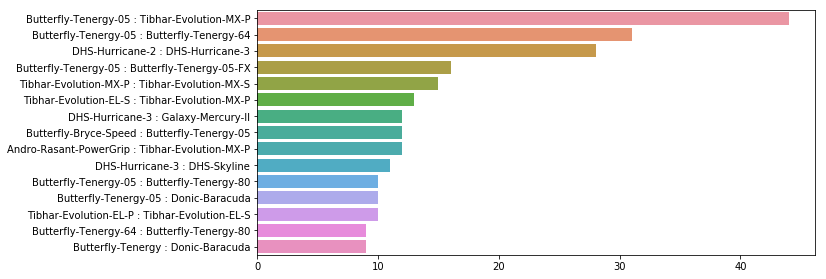

In [131]:
comps = []
for ind, row in df_output.iterrows():
    comps.append(row.entity1 + ' : ' + row.entity2)
plot_most_bar(comps, 15)

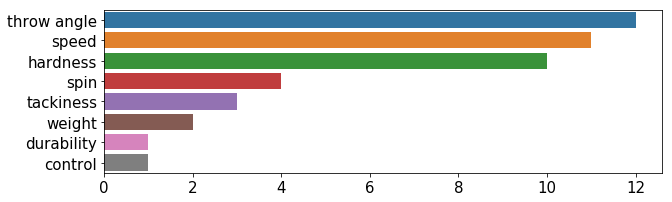

In [157]:
comps = []
for ind, row in df_output.iterrows():
    if row.entity1 == 'Butterfly-Tenergy-05' and row.entity2 == 'Tibhar-Evolution-MX-P':
        comps.append(row.aspect)
plot_most_bar(comps, 10)

In [155]:
df_output.head()

,id,comment_id,comment_text,entity1,entity2,aspect,direction
0,NaN,5f686bc7b59794ca78c70902,I used T05fx before and I really appreciate th...,Butterfly-Tenergy-05-FX,Butterfly-Tenergy-64-FX,speed,l
1,NaN,5f686bc7b59794ca78c70902,I used T05fx before and I really appreciate th...,Butterfly-Tenergy-05-FX,Butterfly-Tenergy-64-FX,hardness,g
2,NaN,5f686bdbb59794ca78c7090b,"T05 pimples are a little shorter, thicker, and...",Butterfly-Tenergy-05,Butterfly-Tenergy-80,hardness,g
3,NaN,5f686bdbb59794ca78c7090b,"1) T05: Slower, More Spin, Higher Throw Angle.",Butterfly-Tenergy-05,Butterfly-Tenergy-80,spin,g
4,NaN,5f686bdbb59794ca78c7090b,"1) T05: Slower, More Spin, Higher Throw Angle.",Butterfly-Tenergy-05,Butterfly-Tenergy-80,speed,l


In [133]:
df_output.to_csv('rubber_comparison_output.csv',sep='|')